# Final Project: How Does Musical Key Vary Across Genres?
Author: Toby Draper

DS 2023

# Notebook 2: Explore Data

In this notebook, we explore the cleaned data from Notebook 1 to identify patterns and insights regarding how musical key varies across genres. At the end, we will have generated visualizations to better understand the distribution of keys within each genre.

Below is a  code cell containing the code from the previous notebook. As the new code in this notebook is dependent on the code from the previous notebook, you must run this first cell before running any subsequent cells in this notebook.

In [2]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import math
import os

# =========================================================
# 1) LOAD DATA 
# =========================================================
df = pd.read_csv("../Spotify_Song_Attributes.csv")

# Keep only what we need for this infographic
df_small = df[["genre", "key"]].copy()
df_small["genre"] = df_small["genre"].astype(str)

# Map Spotify "key" integers (0–11) to note names
key_map = {
    0: "C", 1: "C#", 2: "D", 3: "D#", 4: "E", 5: "F",
    6: "F#", 7: "G", 8: "G#", 9: "A", 10: "A#", 11: "B"
}
df_small["key_note"] = df_small["key"].map(key_map)
key_order = list(key_map.values())

df_small = df_small[["genre", "key_note"]].copy()

## Define Genre Filters:
We will now define keyword lists for each target genre and convert them into regular-expression patterns, allowing us to consistently filter the dataset into Rap, Rock, Pop, and Classical songs based on the text in the genre column.

In [3]:
# =========================================================
# 2) DEFINE GENRE FILTERS (REGEX PATTERNS)
# =========================================================
rap_keywords = ["rap", "hip hop", "hip-hop", "trap", "drill", "boom bap"]
rock_keywords = ["rock", "punk", "metal", "grunge", "alternative", "indie"]
pop_keywords = ["pop", "dance", "electropop", "synthpop", "k-pop", "bubblegum pop"]
classical_keywords = [
    "classical", "orchestral", "orchestra", "baroque",
    "romantic", "symphony", "opera", "renaissance"
]

def make_pattern(words):
    return "|".join(re.escape(w) for w in words)

genre_patterns = {
    "Rap": make_pattern(rap_keywords),
    "Rock": make_pattern(rock_keywords),
    "Pop": make_pattern(pop_keywords),
    "Classical": make_pattern(classical_keywords)
}

## Helper Functions and First Tables
Next, we define helper functions to filter songs into each genre and convert their key counts into consistent percentage distributions. From there, we build derived tables that summarize those percentages by genre, rank the keys from most to least common, and extract the top three keys per genre for plotting, along with shared axis settings so the charts are directly comparable.

In [4]:
# =========================================================
# 3) DATA HELPERS + DERIVED TABLES
# =========================================================
def keys_for_genre(pattern: str) -> pd.Series:
    """Return key_note values for rows whose genre matches the pattern."""
    mask = df_small["genre"].str.contains(pattern, case=False, na=False)
    return df_small.loc[mask, "key_note"]

def percentage_by_key(key_series: pd.Series) -> pd.Series:
    """Return percent distribution across keys in a consistent key order."""
    counts = key_series.value_counts(normalize=True) * 100
    return counts.reindex(key_order, fill_value=0.0)

# Build percent-by-key for each genre (rounded exactly as before)
pct_df = pd.DataFrame({
    genre: percentage_by_key(keys_for_genre(pattern))
    for genre, pattern in genre_patterns.items()
}).round(1)

# Sort each genre's key distribution descending (for top-3 bars)
sorted_dfs = {}
for genre in pct_df.columns:
    df_gen = pd.DataFrame({
        "Key": pct_df.index,
        "Percentage": pct_df[genre].values
    }).sort_values(by="Percentage", ascending=False)
    sorted_dfs[genre] = df_gen

rap_top3       = sorted_dfs["Rap"].head(3).copy()
rock_top3      = sorted_dfs["Rock"].head(3).copy()
pop_top3       = sorted_dfs["Pop"].head(3).copy()
classical_top3 = sorted_dfs["Classical"].head(3).copy()

# Shared scale settings (used by BOTH the bar charts and the heatmap)
max_pct_overall = max(
    rap_top3["Percentage"].max(),
    rock_top3["Percentage"].max(),
    pop_top3["Percentage"].max(),
    classical_top3["Percentage"].max()
)
max_xlim = math.ceil(max_pct_overall / 10.0) * 10
xticks = list(range(0, max_xlim + 1, 2)) 


In [5]:
rap_top3

,Key,Percentage
1,C#,12.8
0,C,10.7
4,E,9.7


In [6]:
rock_top3

,Key,Percentage
0,C,11.6
9,A,11.0
7,G,10.1


In [7]:
pop_top3

,Key,Percentage
0,C,12.4
1,C#,11.7
11,B,9.5


In [8]:
classical_top3

,Key,Percentage
7,G,19.4
2,D,16.7
9,A,12.0


## Set Plotting Style
We will now set the global plotting style for the visualizations, including font settings, color palettes, and Seaborn themes to ensure a consistent and visually appealing design throughout the infographic. Furthermore, we set an output directory to save the generated images to the assets folder.

In [9]:
# =========================================================
# 4) PLOTTING STYLE 
# =========================================================

# Register Times New Roman 
tnr_path = "/System/Library/Fonts/Supplemental/Times New Roman.ttf"
tnr_bold_path = "/System/Library/Fonts/Supplemental/Times New Roman Bold.ttf"
tnr_italic_path = "/System/Library/Fonts/Supplemental/Times New Roman Italic.ttf"
tnr_bold_italic_path = "/System/Library/Fonts/Supplemental/Times New Roman Bold Italic.ttf"

fm.fontManager.addfont(tnr_path)
fm.fontManager.addfont(tnr_bold_path)
fm.fontManager.addfont(tnr_italic_path)
fm.fontManager.addfont(tnr_bold_italic_path)

# FontProperties used explicitly for the heatmap colorbar tick labels
tnr_fp = fm.FontProperties(fname=tnr_path)

# Global plotting defaults
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "text.color": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "axes.titlecolor": "white",
})

# Seaborn theme 
sns.set_theme(style="white", font_scale=1.2)

# Color palette for bar charts 
blues_palette_bars = sns.color_palette("Blues_r", n_colors=len(key_order))
key_family_colors = dict(zip(key_order, blues_palette_bars))

# =========================================================
# 4.5) OUTPUT DIRECTORY (SAVE IMAGES TO assets/)
# =========================================================
ASSETS_DIR = "assets"
os.makedirs(ASSETS_DIR, exist_ok=True)

## First Visualization: 2x2 Bar Charts
With the plotting style set, we create our first visualization: a 2x2 grid of bar charts showing the top three most common keys for each genre. 

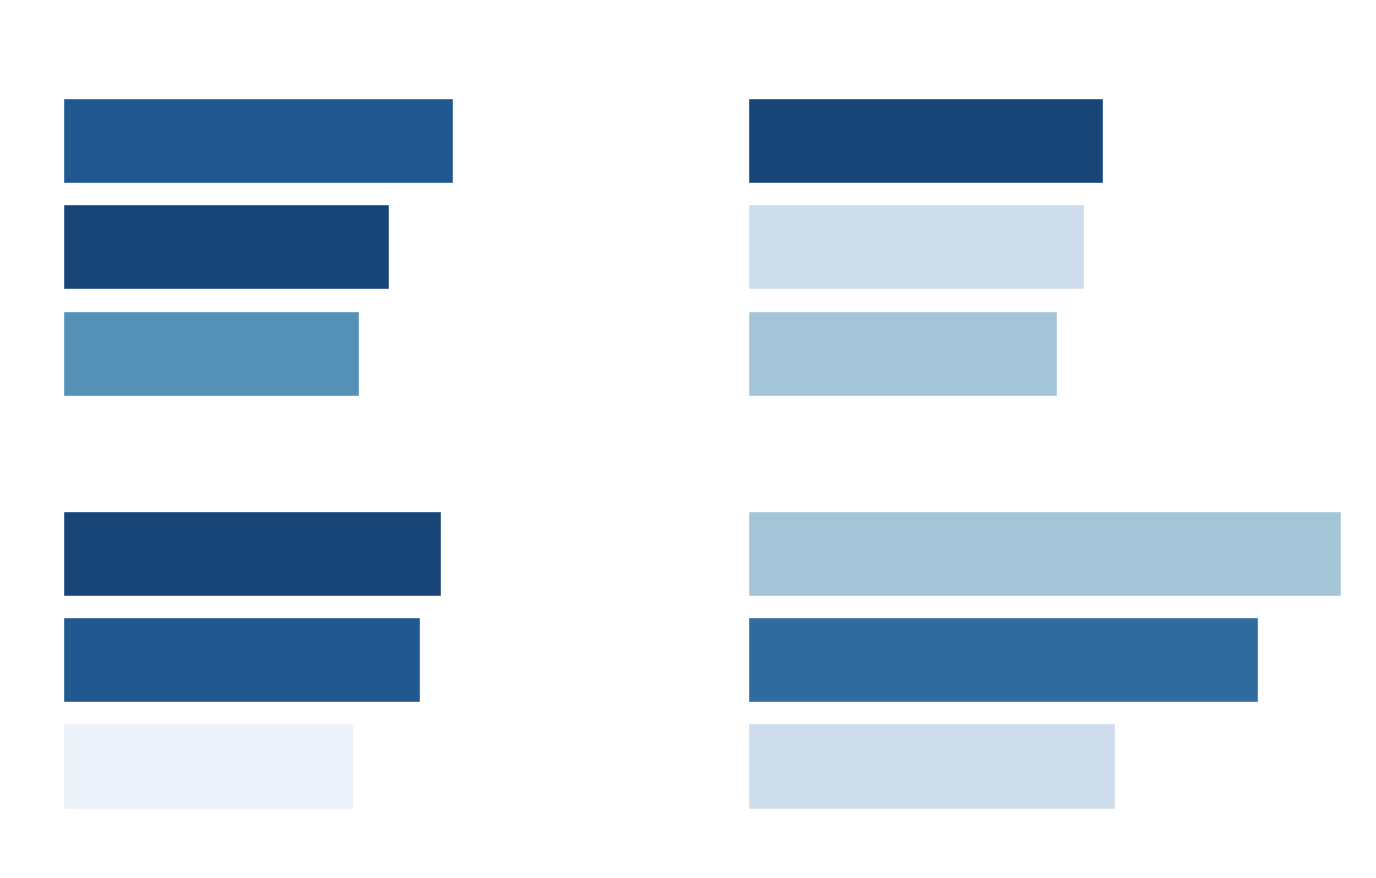

In [10]:
# =========================================================
# 5) VISUALIZATION 1 — BAR CHARTS (2×2)
# =========================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.patch.set_alpha(0)

for ax in axes.flat:
    ax.set_facecolor("none")

plot_data = [
    ("Rap", rap_top3, axes[0, 0]),
    ("Rock", rock_top3, axes[0, 1]),
    ("Pop", pop_top3, axes[1, 0]),
    ("Classical", classical_top3, axes[1, 1])
]

for genre, df_genre, ax in plot_data:

    sns.barplot(
        data=df_genre,
        x="Percentage",
        y="Key",
        ax=ax,
        hue="Key",
        palette=key_family_colors,
        dodge=False,
        legend=False
    )

    ax.set_title(
        f"Most Common Keys in {genre}",
        fontsize=16,
        color="white",
        fontfamily="Times New Roman"
    )

    ax.set_xlabel(
        "Percentage of Songs (%)",
        fontsize=12,
        color="white",
        fontfamily="Times New Roman"
    )
    ax.set_ylabel(
        "Key",
        fontsize=12,
        color="white",
        fontfamily="Times New Roman"
    )

    ax.set_xlim(0, max_xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(
        [str(tick) for tick in xticks],
        fontsize=11,
        color="white",
        fontfamily="Times New Roman"
    )
    
    ax.set_yticks(range(len(df_genre)))
    ax.set_yticklabels(
        df_genre["Key"],
        fontsize=11,
        color="white",
        fontfamily="Times New Roman"
    )

    ax.grid(False)

    for spine in ax.spines.values():
        spine.set_color("white")
        spine.set_linewidth(1.2)

fig.suptitle(
    "Most Common Keys by Music Genre",
    fontsize=25,
    color="white",
    fontfamily="Times New Roman",
    y=0.88
)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

## Visualization 2: Heatmap
Next, we create a heatmap to visualize the distribution of all keys across the four genres, allowing us to see patterns and differences in key usage at a glance.

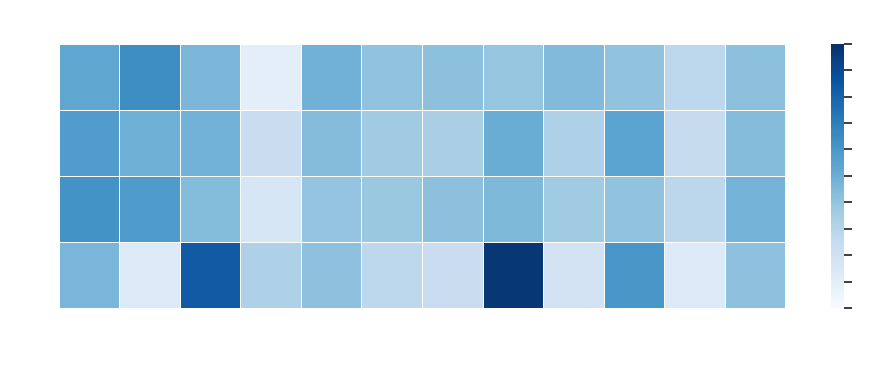

In [11]:
# =========================================================
# 6) VISUALIZATION 2 — HEATMAP (PERCENTAGES)
# =========================================================
heatmap_counts = {}
for genre, pattern in genre_patterns.items():
    mask = df_small["genre"].str.contains(pattern, case=False, na=False)
    keys = df_small.loc[mask, "key_note"]
    counts = keys.value_counts().reindex(key_order, fill_value=0)
    heatmap_counts[genre] = counts

heatmap_df = pd.DataFrame(heatmap_counts).T.loc[["Rap", "Rock", "Pop", "Classical"]]

heatmap_prop = heatmap_df.div(heatmap_df.sum(axis=1), axis=0)
heatmap_pct = heatmap_prop * 100

plt.figure(figsize=(10, 4))
plt.gcf().patch.set_alpha(0)
plt.gca().set_facecolor("none")

ax = sns.heatmap(
    heatmap_pct,
    annot=False,
    linewidths=0.5,
    cmap="Blues",
    vmin=0,
    vmax=max_xlim,
    cbar_kws={"format": "%.0f%%", "ticks": xticks}
)

plt.title(
    "Distribution of Keys by Music Genre",
    fontsize=16,
    pad=14,
    color="white",
    fontfamily="Times New Roman"
)

plt.xlabel("Key", fontsize=12, color="white", fontfamily="Times New Roman")
plt.ylabel("Genre", fontsize=12, color="white", fontfamily="Times New Roman")

ax.set_xticklabels(
    key_order,
    rotation=45,
    ha="right",
    fontsize=11,
    color="white",
    fontfamily="Times New Roman"
)

ax.set_yticks(range(len(heatmap_df.index)))
ax.set_yticklabels(
    heatmap_df.index,
    fontsize=11,
    color="white",
    fontfamily="Times New Roman"
);

# Force Times New Roman styling on colorbar tick labels
cbar = ax.collections[0].colorbar
for lab in cbar.ax.get_yticklabels():
    lab.set_fontproperties(tnr_fp)
    lab.set_color("white")
    lab.set_fontsize(10)

plt.tight_layout()
plt.savefig("genre_key_heatmap_proportion.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

We have now successfully created 2 visually appealing visualizations that explore how musical key varies across genres. These visualizations will be used in the final infographic to communicate our findings.